In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

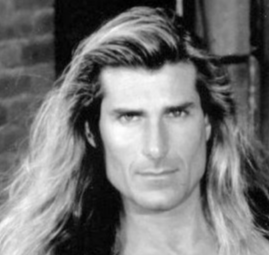

In [2]:
require 'image'
filter = image.gaussian(3)
filter:div(filter:sum())
input = image.convolve(image.fabio(), filter)
itorch.image(input)

20	0	


101	0	
20	0	
101	0	


-40	0	
61	0	
-40	0	
61	0	


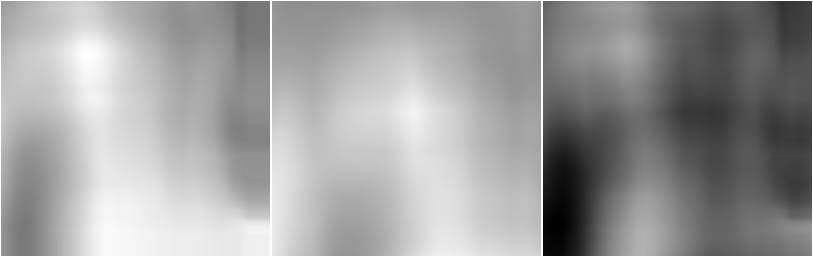

In [3]:
Integral = nil
IntegralSmartNorm = nil
debug.getregistry()['Integral'] = nil 
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['Integral'] = nil
package.loaded['IntegralSmartNorm'] = nil

require 'nn'
require 'IntegralSmartNorm'

refInt = IntegralSmartNorm(2, input:size(1), input:size(2)):type(input:type())

refRects = {{20, 20, 100, 100}, {-40, -40, 60, 60}}

for k = 1,2 do
    refInt.xMin[k], refInt.yMin[k], refInt.xMax[k], refInt.yMax[k] = table.unpack(refRects[k])
end

targetSeparate = refInt:forward(input)
target = targetSeparate[1] - targetSeparate[2]
itorch.image{targetSeparate[1], targetSeparate[2], target}

In [4]:
require 'WindowDebugger'

wDeb = WindowDebugger()

torch.manualSeed(667)

int = IntegralSmartNorm(2, input:size(1), input:size(2)):type(input:type())
int.exact = true
int.maxX = 1e9
int.maxY = 1e9

conv = nn.SpatialConvolution(2, 1, 1,1,1,1)
conv.weight[1][1][1][1] = 1
conv.weight[1][2][1][1] = -1
conv.bias[1] = 0 

net = nn.Sequential()
net:add(int)
net:add(conv)

crit = nn.MSECriterion():type(input:type())

params, gradParams = int:getParameters()

-- int.xMin[1] = refRects[1][1]
-- int.yMin[1] = refRects[1][2]
-- int.xMax[1] = refRects[1][3]
-- int.yMax[1] = refRects[1][4]

-- int.xMin[2] = refRects[2][1]
-- int.yMin[2] = refRects[2][2]
-- int.xMax[2] = 150
-- int.yMax[2] = 150

-- params = torch.Tensor(params:storage(), 4, 2, 4)
-- gradParams = torch.Tensor(gradParams:storage(), 4, 2, 4)

In [178]:
require 'optim'

optimState = {
    learningRate = 1e1,
    momentum = 0.7,
    nesterov = true,
    dampening = 0
}

In [179]:
outputDir = 'Test-simple-Haar/1/'
os.execute('mkdir "' .. outputDir .. '" -p')
    
logger = optim.Logger(outputDir .. 'accuracy.log')
logger:setNames{'Loss'}
logger:style{'-'}

In [180]:
local diffGrad = false

for k = 1,100 do
    local feval
    
    if diffGrad then
        feval = 
            function(x)
                gradParams:zero()
                pred = net:forward(input)
                local loss = crit:forward(pred, target)
            
                -- compute the finite difference approximation of the gradient
                local stepSize = 1
                for win = 1,int.nWindows do
                    for _, attr in ipairs{'xMin', 'xMax', 'yMin', 'yMax'} do
                        local attrPrev = int[attr][win]
                        int[attr][win] = attrPrev - 0.5*stepSize
                        local lossMinus = crit:forward(net:forward(input), target)
                        int[attr][win] = attrPrev + 0.5*stepSize
                        local lossPlus = crit:forward(net:forward(input), target)
                        
                        int['grad' .. attr:gsub("^%l", string.upper)][win] = 
                            (lossPlus - lossMinus) / stepSize
                    end
                end

                return loss, gradParams
            end
    else
        feval = 
            function(x)
                gradParams:zero()
                pred = net:forward(input)
                local loss = crit:forward(pred, target)
                local dloss_doutputs = crit:backward(pred, target)
                net:backward(input, dloss_doutputs)

                return loss, gradParams
            end
    end

    local _, loss = optim.adam(feval, params, optimState)
    logger:add{loss[1]}
    
    wDeb:add(int)
    
    logger:plot()
end

In [181]:
wDeb:exportVideo(outputDir .. 'int.avi', refRects)

### Plot the loss surface in `(xMax[2], yMax[2])` coordinates

In [5]:
-- debug that issue about 0-s on outputOnes
intTest = IntegralSmartNorm(1, 6, 6)
inputTest = torch.linspace(0, 9, 36):view(6,6)
intTest.exact = true

intTest.xMin[1] = -2.762847900391
intTest.xMax[1] = -2.494789123535
intTest.yMin[1] = 1 --4.014869689941
intTest.yMax[1] = 1 --3.225112915039

intTest:forward(inputTest)
print(inputTest)
print(intTest.outputNonNorm)
print(intTest.outputOnes)

-2	0.76284790039062	
-2	0.50521087646484	
1	0	


2	0	


(1,.,.) = 
 -12.2083  -0.2416   0.0079   0.1773   0.3264   0.3264
 -12.2083  -0.2416   0.0079   0.1773   0.3264   0.3264
   0.2571   0.5143   0.7714   1.0286   1.2857   1.2857
   0.8718   1.1290   1.3861   1.6433   1.9004   1.9004
   2.4147   2.6718   2.9290   3.1861   3.4433   3.4433
   3.9576   4.2147   4.4718   4.7290   4.9861   4.9861
[torch.FloatTensor of size 1x6x6]

 0.0000  0.2571  0.5143  0.7714  1.0286  1.2857
 1.5429  1.8000  2.0571  2.3143  2.5714  2.8286
 3.0857  3.3429  3.6000  3.8571  4.1143  4.3714
 4.6286  4.8857  5.1429  5.4000  5.6571  5.9143
 6.1714  6.4286  6.6857  6.9429  7.2000  7.4571
 7.7143  7.9714  8.2286  8.4857  8.7429  9.0000
[torch.FloatTensor of size 6x6]

(1,.,.) = 
  0.1272  0.1246 -0.0080 -0.2705 -0.6630 -0.6630
  0.1272  0.1246 -0.0080 -0.2705 -0.6630 -0.6630
  0.2571  0.5143  0.7714  1.0286  1.2857  1.2857
  1.1055  1.4316  1.7577  2.0838  2.4098  2.4098
  3.0620  3.3880  3.7141  4.0402  4.3663  4.3663
  5.0184  5.3445  5.6706  5.9966  6.3227  6.322

194 steps to do	


15	


30	


45	


60	


75	

90	


105	


120	


135	


150	


165	


180	


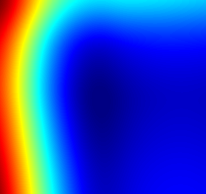

In [12]:
xMaxGrid = torch.range(int.xMin[2], int.xMin[2] + input:size(1)*0.85, 1)
yMaxGrid = torch.range(int.yMin[2], int.yMin[2] + input:size(2)*0.85, 1)
surface = torch.Tensor(xMaxGrid:nElement(), yMaxGrid:nElement()):random()

print(xMaxGrid:nElement() .. ' steps to make')

for i = 1,xMaxGrid:nElement() do
    for j = 1,yMaxGrid:nElement() do
        int.xMax[2] = xMaxGrid[i]
        int.yMax[2] = yMaxGrid[j]
        
        surface[{i,j}] = crit:forward(net:forward(input), target)
    end
    if i % 15 == 0 then
        print(i)
    end
end

function prepareForColorize(img)
    local retval = img:clone()
    retval:div(math.max(math.abs(img:max()), math.abs(img:min())))
    retval:add(-retval:min())
    retval:mul(255 / retval:max())
    retval:add(1e-2)
    assert(retval:min() > 0 and retval:min() < 2)
    assert(retval:max() > 0 and retval:max() < 256)
    
    return retval
end

itorch.image(image.y2jet(prepareForColorize(surface)))